Import libraries

In [66]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Import files

In [67]:
characters = pd.read_csv("../Clean data/clean_character_data.csv")
movies = pd.read_csv("../Clean data/clean_movie_data.csv")
inputs = pd.read_csv("../Clean data/inputs.csv")

column_names = list(inputs.columns)
print(column_names)

['Wiki ID', 'Freebase ID_x', 'Movie name', 'Release date_x', 'Revenue', 'Runtime', 'IMDb rating', 'Wins', 'Nominations', 'Release year_x', 'Languages', 'Genres', 'Countries', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-on

Quick look at inputs

In [68]:
inputs.head()

,Wiki ID,Freebase ID_x,Movie name,Release date_x,Revenue,Runtime,IMDb rating,Wins,Nominations,Release year_x,...,Actor birth year_y,F-onehot_y,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Pacific Islander_y,Other_y
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.315268e+07,98.0,4.9,NaN,2.0,2001,...,1969.0,0.0,1.0,0,1,0,0,0,0,0
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,5.8,NaN,NaN,1997,...,1964.0,1.0,0.0,0,0,0,0,0,0,1
2,171005,/m/016ywb,Henry V,1989-11-08,2.398142e+07,137.0,7.5,12.0,13.0,1989,...,1959.0,1.0,0.0,1,0,0,0,0,0,0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,9.655040e+08,139.0,7.8,22.0,17.0,1964,...,1917.0,0.0,1.0,0,0,0,0,0,0,1
4,156558,/m/014k4y,Baby Boy,2001-06-27,4.855272e+07,123.0,6.4,1.0,14.0,2001,...,1970.0,1.0,0.0,0,1,0,0,0,0,0


In [69]:
inputs.shape

(10918, 105)

In [70]:
# Assuming 'Revenues' is the column in your DataFrame 'df'
max_revenue = inputs['Revenue'].max()
min_revenue = inputs['Revenue'].min()

print("Maximum Revenue:", max_revenue)
print("Minimum Revenue:", min_revenue)


Maximum Revenue: 9522959437.465649
Minimum Revenue: 336.5110586513585


In [71]:
# DataFrame with revenues higher than 1,000,000,000
high_revenue_df = inputs[inputs['Revenue'] > 1000000000]

# DataFrame with revenues lower than 1,000
low_revenue_df = inputs[inputs['Revenue'] < 1000000]

In [72]:
high_revenue_df.shape

(99, 105)

In [73]:
low_revenue_df.shape

(952, 105)

All inputs analysis

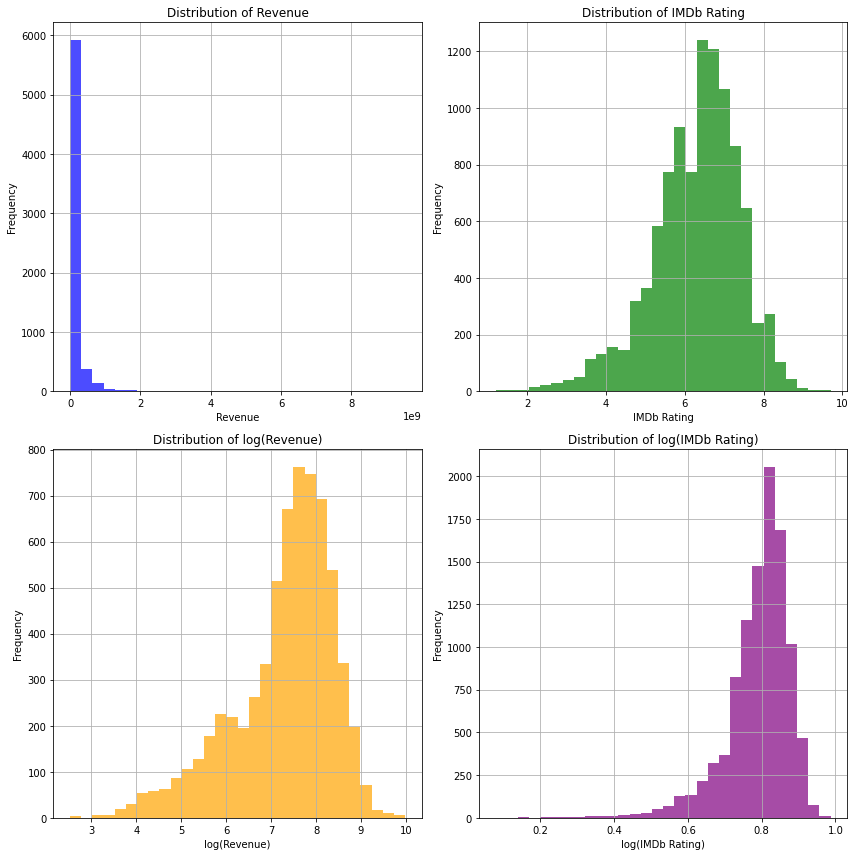

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = inputs['Revenue']
imdb_ratings = inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Tail-cut inputs analysis

In [75]:
min_revenue_threshold = 100000  # Set your minimum revenue threshold
max_revenue_threshold = 1000000000  # Set your maximum revenue threshold

filtered_revenues_inputs = inputs[(inputs['Revenue'] > min_revenue_threshold) & (inputs['Revenue'] < max_revenue_threshold)]

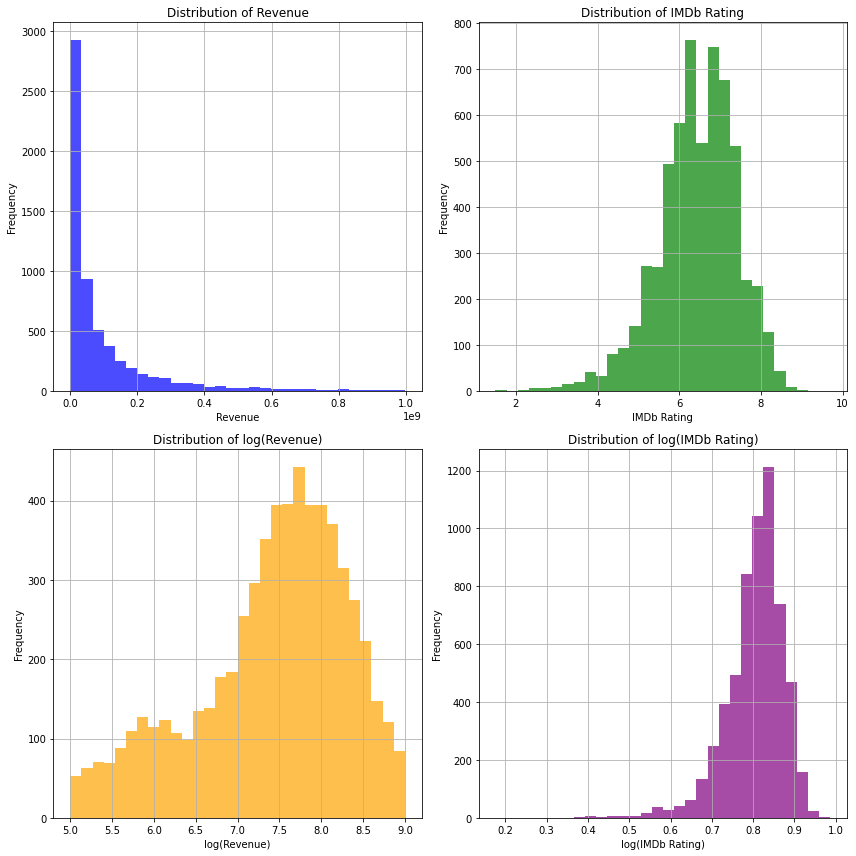

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = filtered_revenues_inputs['Revenue']
imdb_ratings = filtered_revenues_inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Modelling functions

In [77]:
def feat_and_target_revenue(data):
    feature = data.drop('Revenue', axis = 1)
    target = np.log10(data['Revenue'])

    return feature, target

In [78]:
def feat_and_target_critics(data):
    feature = data.drop('IMDb rating', axis = 1)
    target = np.log10(data['IMDb rating'])

    return feature, target

In [79]:
def data_splitting(feature, target):
    #Returns x_train, x_test, y_train, y_test
    return train_test_split(feature, target, test_size=0.2, random_state=42) 

In [80]:
def fit_model(model_name, xtrain, xtest, ytrain, ytest):
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=13,
    max_features=0.5044385141334264,
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=140,
    random_state=42
)  # Adjust parameters as needed
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.5382140919340437, 
    gamma = 1.0628444205682614,
    max_depth = 7, 
    min_child_weight = 1, 
    n_estimators = 70, 
    reg_alpha = 40
)
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.048040737541705625,
    max_depth=4,
    min_samples_leaf=8,
    min_samples_split=5,
    n_estimators=200,
    subsample=0.7977456176958748,
    random_state=42
)

    else:
        print("Invalid model name.")
        return
    
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    if model_name == 'XGBoost':
        plot_importance(model, max_num_features=30)  # This function is specific to XGBoost
    else:
        # Plotting histograms for RandomForest and GBM
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Distribution of Predictions')
        axes[0].set_xlabel('Predictions')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
        axes[1].set_title('Actual Values')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()




In [81]:
def pipeline_revenue(data, model_name):
    feature, target = feat_and_target_revenue(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model(model_name, xtrain, xtest, ytrain, ytest)
def pipeline_critics(data, model_name):
    feature, target = feat_and_target_critics(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model(model_name, xtrain, xtest, ytrain, ytest)

#'XGB': Refers to the XGBoostRegressor model.
#'RandomForest': Refers to the RandomForestRegressor model from scikit-learn.
#'GBM': Refers to the GradientBoostingRegressor model from scikit-learn.

Inputs formation

In [82]:
to_keep = ['IMDb rating','M-onehot_x', 'M-onehot_y', 'Revenue', 'Runtime', 'Release year_x', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Other_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y', 'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Other_y']
#'IMDb rating', 'Wins', 'Nominations','M-onehot_x', 'M-onehot_y'

all_inputs = inputs[to_keep]
inputs_filt = filtered_revenues_inputs[to_keep]

print("Number of features is: " + str(len(to_keep)))
all_inputs = all_inputs.dropna()

# List of columns to drop
columns_to_drop = ['Actor height_x', 'Actor height_y']
# Dropping the specified columns
inputs_filt.drop(columns=columns_to_drop, inplace=True)
inputs_filt = inputs_filt.dropna()

print(all_inputs.shape)
print(inputs_filt.shape)


Number of features is: 68
(4753, 68)
(5516, 66)


<ipython-input-82-1adab04416e6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_filt.drop(columns=columns_to_drop, inplace=True)


In [83]:
inputs_interest = inputs[['Runtime', 'IMDb rating', 'Release year_x',
                'Adventure-onehot', 'Drama-onehot', 'Indie-onehot',
                'Actor age at release_x', 'Actor age at release_y', 'Revenue']]


nan_counts = inputs_interest.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}' has {count} NaN values.")

inputs_interest = inputs_interest.dropna()
print(inputs_interest.shape)

Column 'Runtime' has 622 NaN values.
Column 'IMDb rating' has 750 NaN values.
Column 'Release year_x' has 0 NaN values.
Column 'Adventure-onehot' has 0 NaN values.
Column 'Drama-onehot' has 0 NaN values.
Column 'Indie-onehot' has 0 NaN values.
Column 'Actor age at release_x' has 619 NaN values.
Column 'Actor age at release_y' has 867 NaN values.
Column 'Revenue' has 4385 NaN values.
(5875, 9)


RMSE: 0.058197830705919176
Std: 0.06731368953581902
Mean Absolut Error: 0.043122470477750356


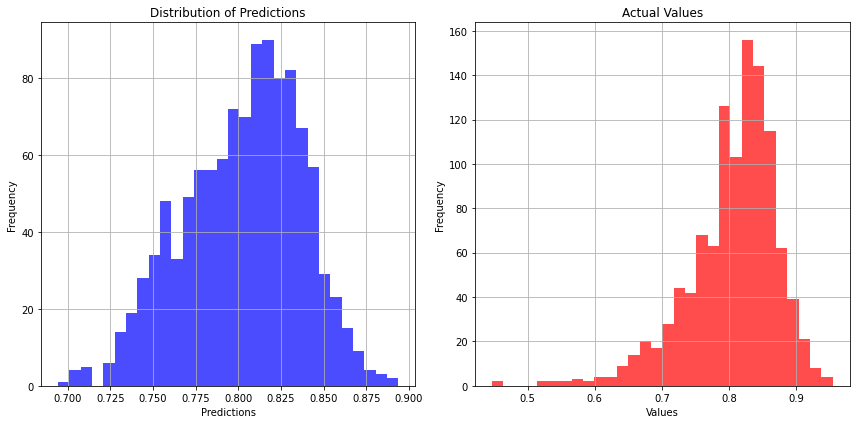

In [88]:
pipeline_critics(inputs_filt, 'RandomForest')

Hyperparametr tuning

In [93]:
space_GBM = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

In [94]:
space_RandomForest = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.5, 1)
}

In [95]:
space_XGB = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5)
}


In [110]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np

def hyperopt_tuning(algo_type, space, data, goal):
    if goal == 'Revenue':
        feature, target = feat_and_target_revenue(data)
    elif goal == 'Critics':
        feature, target = feat_and_target_critics(data)
    else:
        raise ValueError("Goal not understood")
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    def objective(space):
        if algo_type == 'XGB':
            clf = xgb.XGBRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                subsample=space['subsample'],
                colsample_bytree=space['colsample_bytree'],
                gamma=space['gamma'],
                min_child_weight=space['min_child_weight'],
                reg_alpha=space['reg_alpha'],
                reg_lambda=space['reg_lambda']
            )
        elif algo_type == 'GBM':
            clf = GradientBoostingRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                subsample=space['subsample'],
                random_state=42
            )
        elif algo_type == 'RandomForest':
            clf = RandomForestRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                random_state=42
            )
        else:
            raise ValueError("Invalid algorithm type. Supported types are 'XGB', 'GBM', 'RandomForest'")
        
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
        mean_mse = np.mean(-mse_scores)
        
        return {'loss': mean_mse, 'status': STATUS_OK}
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 10,
                            trials = trials)

    for i, result in enumerate(trials.results):
        hyperparameters = trials.trials[i]['misc']['vals']
        score = result['loss']
        print(f"Trial {i+1}: Hyperparameters - {hyperparameters}, Score - {score}")

    
    return best, trials


In [111]:
hyperopt_tuning('RandomForest', space_RandomForest, inputs_filt, 'Critics')

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

 90%|█████████ | 9/10 [06:34<00:48, 48.93s/trial, best loss: 0.00399345001390391] 

In [286]:
feature, target = feat_and_target(inputs_filt)
xtrain, xtest, ytrain, ytest = data_splitting(feature, target)

def objective(space):
    # Define XGBoost regressor with hyperparameters from 'space'
    clf = GradientBoostingRegressor(
        #objective='reg:squarederror',
        #eta = int(space['eta']),
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=int(space['learning_rate']),
        min_samples_split=space['min_samples_split'],
        min_samples_leaf=space['min_samples_leaf'],
        #reg_lambda=space['reg_lambda']
        subsample=space['sample']
    )
    
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
    
    # Calculate mean MSE from cross-validation scores
    mean_mse = np.mean(-mse_scores)
    print(mean_mse)
    # Return result to Hyperopt
    return {'loss': mean_mse, 'status': STATUS_OK}

In [309]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials

# Define the hyperparameter space for RandomForestRegressor
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.5, 1)
}

# Assuming xtrain, ytrain are available from your previous code
def objective(space):
    # Define RandomForestRegressor with hyperparameters from 'space'
    clf = RandomForestRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_samples_leaf']),
        max_features=space['max_features'],
        random_state=42
    )
    
    # Perform 10-fold cross-validation (assuming xtrain, ytrain are available)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
    
    # Calculate mean MSE from cross-validation scores
    mean_mse = np.mean(-mse_scores)
    print(mean_mse)
    # Return result to Hyperopt
    return {'loss': mean_mse, 'status': 'ok'}



In [310]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 80,
                        trials = trials)

for i, result in enumerate(trials.results):
    hyperparameters = trials.trials[i]['misc']['vals']
    score = result['loss']
    print(f"Trial {i+1}: Hyperparameters - {hyperparameters}, Score - {score}")

0.5123278580157014                                    
0.5285577167209359                                                              
0.5043018526424021                                                              
0.5051924877894924                                                              
0.5082296144428027                                                              
0.5116233459241836                                                              
0.5142011976063341                                                              
0.5081859527856004                                                              
0.5116348452287309                                                              
0.5075810937717591                                                              
0.5130498762348052                                                               
0.5117966138988568                                                               
0.52026566815665                                    

In [297]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials

feature, target = feat_and_target(inputs_filt)
xtrain, xtest, ytrain, ytest = data_splitting(feature, target)

# Define the hyperparameter space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

def objective(space):
    clf = GradientBoostingRegressor(
        loss='squared_error',  # This parameter should be 'ls' for least squares regression
        learning_rate=space['learning_rate'],
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_samples_leaf']),
        subsample=space['subsample'],
        random_state=42
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
    
    mean_mse = np.mean(mse_scores)
    print(mean_mse)
    return {'loss': mean_mse, 'status': 'ok'}

trials = Trials()
best_hyperparams = fmin(fn=objective,
                       space=space,
                       algo=tpe.suggest,
                       max_evals=30,
                       trials=trials)


  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

0.5617923491555183                                    
0.5395325352095628                                                              
0.591272443258795                                                               
0.568982042723927                                                               
0.5050848755247772                                                              
0.5989069893725837                                                              
0.5635475200090283                                                              
0.5843891176750521                                                              
0.5629429449744904                                                              
0.5186637764129147                                                              
0.5982298396683194                                                               
0.5982303518869383                                                               
0.5024942487823378                                  

In [311]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'max_depth': 13.0, 'max_features': 0.5044385141334264, 'min_samples_leaf': 4.0, 'min_samples_split': 15.0, 'n_estimators': 140.0}


In [ ]:
'''
from sklearn.feature_selection import RFE
from sklearn.svm import SVR  # For regression tasks; for classification, use SVC

# Assuming 'data' contains your features
# 'target' is your target variable
def which_feat(x,y):
    # Initialize an SVM regressor
    estimator = SVR(kernel='linear')

    # Initialize RFE with the estimator and number of features to select
    rfe = RFE(estimator, n_features_to_select=10)  # Specify the number of features to select

    # Fit RFE to your data
    rfe.fit(x, y)

    # Selected features mask
    selected_mask = rfe.support_

    # Apply the mask to get the selected features
    selected_features_rfe = x.columns[selected_mask]

    # Use the selected features for further modeling
    data_selected_rfe = x[selected_features_rfe]

    print(data_selected_rfe.columns)
'''

In [ ]:
#which_feat(all_inputs_feat, all_inputs_target)

mse 379951837.23281854
Std 344624587.4210548


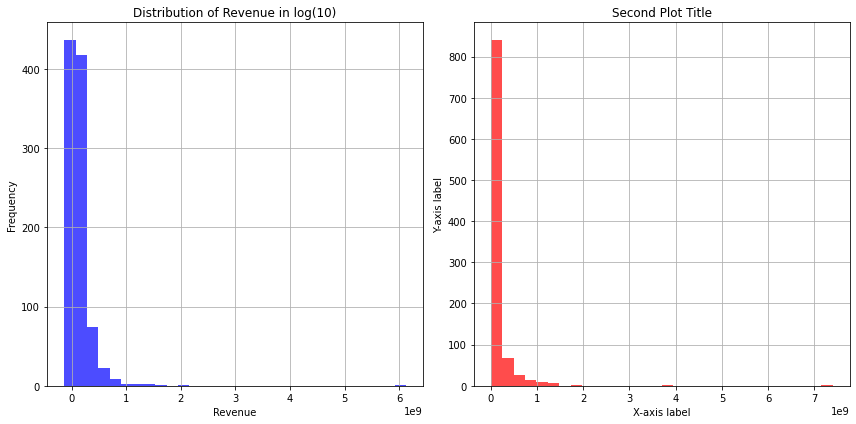

Mean Error: 133906545.26791629


In [ ]:
XGB(xall_inputs_train, xall_inputs_test, yall_inputs_train, yall_inputs_test)

mse 150803167.0402343
Std 158039995.3901813


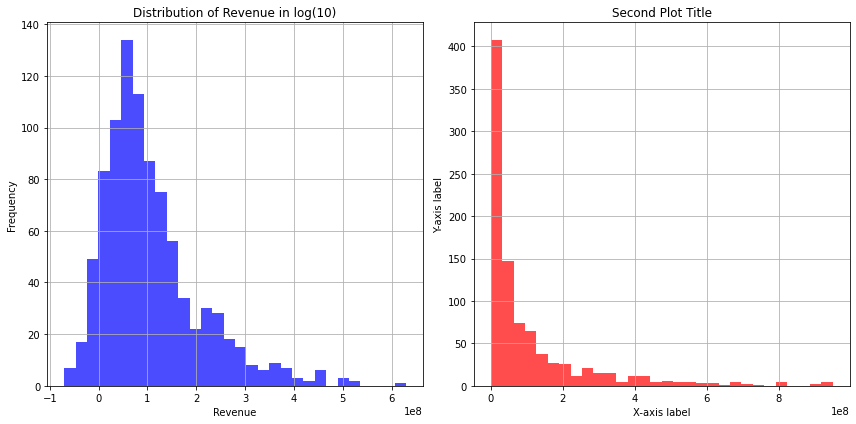

Mean Error: 97222527.55859202


In [ ]:
XGB(xinputs_filt_train, xinputs_filt_test, yinputs_filt_train, yinputs_filt_test)

mse 318416373.57340014
Std 288028351.49950874


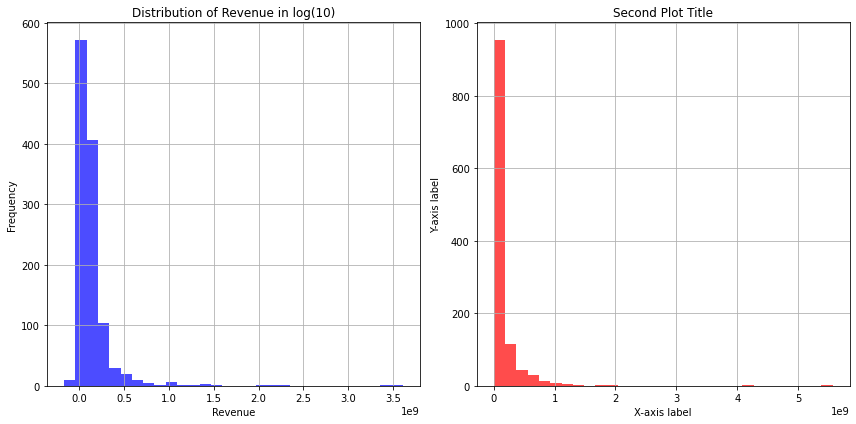

Mean Error: 143413696.01484597


In [ ]:
XGB(xinputs_interest_train, xinputs_interest_test, yinputs_interest_train, yinputs_interest_test)

In [ ]:
#Garder uniquement les features que l'on va utiliser 
# Peut être qu'on utilise ça 'IMDb rating', 'Wins', 'Nominations',
inputs_cleaned= inputs[['Revenue', 'Runtime',  'Release year_x', 'English Language-onehot', 'Tamil Language-onehot', 'Hindi Language-onehot', 'Malayalam Language-onehot', 'German Language-onehot', 'Japanese Language-onehot', 'Korean Language-onehot', 'Spanish Language-onehot', 'Italian Language-onehot', 'French Language-onehot', 'Standard Mandarin-onehot', 'Standard Cantonese-onehot', 'Bengali Language-onehot', 'Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot', 'Portuguese Language-onehot', 'Urdu Language-onehot', 'Arabic Language-onehot', 'Tagalog language-onehot', 'Swedish Language-onehot', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y']]
inputs_cleaned = inputs_cleaned.dropna()
#Mettre les revenus en logarithmique mais pas sur qu'on fasse ça
#inputs_cleaned["Revenue"] = np.log10(inputs['Revenue'])
inputs_cleaned["Revenue"]

0        2.315268e+07
2        2.398142e+07
5        4.855272e+07
10       2.497657e+05
11       9.346851e+06
             ...     
18263    1.097915e+06
18266    9.223044e+08
18267    1.916860e+08
18276    7.143263e+08
18281    1.180217e+07
Name: Revenue, Length: 4844, dtype: float64

In [ ]:
#TEST pour voir si diminuer le nombre des features change quelque chose
#inputs_cleaned = inputs_cleaned[["Revenue",'Runtime','Release year','Primary Actor age at release']]

In [ ]:
# On mets les features dans X et les Revenus dans Y
X = inputs_cleaned.drop('Revenue', axis=1)  # Features
y = inputs_cleaned['Revenue']  # Target variable

#Splitting du data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit le model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

#Des test pour voir si ça fonctionnes
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("mse",math.sqrt(mse))
variance = y_test.std()
print("Std", variance)

mse 0.903306965071381
Std 1.0771125732448288


In [ ]:
for element in y_pred:
    print(element)

8.313767
8.451599
5.6029754
7.656711
7.2957606
6.435615
7.7006574
5.3529553
7.454218
8.332987
6.7946033
8.232753
7.7827554
7.664387
7.8767705
8.747814
7.037436
6.2798686
7.4082527
8.164811
7.460501
7.351157
7.0652876
7.3756948
7.3150396
8.541087
5.8049045
7.035201
5.9461646
6.0859985
8.106104
8.090466
5.941218
7.7500634
7.211997
6.4064045
7.1879354
5.886017
7.9625397
8.132125
6.931157
7.553305
6.8548455
7.67286
7.0453296
6.788922
5.869265
7.602956
7.7726316
7.4879947
8.210527
7.8326573
7.3138227
8.20651
7.6694903
7.6754384
7.4023824
6.2893567
6.704009
8.202305
8.560422
8.105593
6.736525
6.9261794
8.418691
7.356221
7.6217494
7.394224
5.8614116
6.472465
5.2926106
8.559706
7.2910814
7.9217052
7.107577
7.7079644
7.998958
7.1027775
7.13786
7.5474334
8.689077
5.86803
5.994997
7.5907097
6.839483
7.1127973
5.768486
7.6518855
6.09361
6.996807
8.326481
7.2853394
7.030536
7.7137847
8.269083
6.383476
7.1523
8.313122
7.995298
7.722409
7.9038873
8.29811
7.7459793
6.5130167
5.7389507
7.235896
6.06279

In [ ]:
for element in y_test:
    print(element)

max_value = np.max(y_test)
min_value = np.min(y_test)

print("Highest value in test:", max_value)
print("Lowest value:", min_value)

max_value = np.max(y_pred)
min_value = np.min(y_pred)

print("Highest value in pred:", max_value)
print("Lowest value:", min_value)

8.070054085893497
8.556225884315584
3.8451974170391394
4.67067591744719
8.226853900101124
7.3842248674425
6.817531191294152
5.412740177666531
8.036429598515161
7.7780393287685765
6.039465542282045
8.56410017333038
7.705025192588659
7.990447169200559
7.513332461870222
8.650270134650468
5.396751957682388
6.61173062864997
7.172116383985829
7.388786186527921
7.999317989704248
7.422407425894733
7.208395272525201
7.548258964920269
6.631483216881376
8.457792356037661
6.796209848882615
4.660787756118825
5.793583037312236
5.7658773807478
7.513904346597522
8.277106436354622
5.809923440833111
8.714433583818295
6.575117145638445
5.944658889145672
7.623693833599677
7.849117562658597
7.697712574000788
8.389223136347374
7.982411709191872
8.824018175079653
6.6555587234735505
7.973174916645417
8.323606290529733
6.141447863236223
5.0161250419438135
8.286909335300905
7.614224645673506
5.7879483266589276
8.931310462436304
8.5347030108158
7.3128569606550275
8.112362387297978
7.247640803790404
8.14656311886